# 🏭 Machine Failure Prediction and Classification

## 🔍 Problem Statement

Factories aim to reduce machine downtime by predicting and understanding failures. In this notebook, we will build two models:

- **Model 1: Failure Prediction**
  - Type: Binary Classification
  - Goal: Predict whether a machine is likely to fail soon (`Yes` or `No`)
  - Algorithms: Random Forest, Gradient Boosting, Logistic Regression
  - Evaluation: Precision-Recall (since catching failures is critical)

- **Model 2: Failure Type Classification**
  - Type: Multi-Class Classification
  - Goal: Classify the type of failure:
    - Tool wear failure (**TWF**)
    - Heat dissipation failure (**HDF**)
    - Power failure (**PWF**)
    - Overstrain failure (**OSF**)
    - Random failures (**RNF**)
  - Algorithms: Decision Tree, SVM, Naive Bayes, XGBoost
  - Evaluation: Confusion Matrix and Per-Class F1-scores

---
## 📦 Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score

# Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# XGBoost
import xgboost as xgb

## 📁 Step 2: Load Dataset

In [2]:
# Load the dataset
df = pd.read_csv('ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## 🔍 Step 3: Data Exploration & Preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [4]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [5]:
df.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

### Step 1: Binary Target for Model 1

In [6]:
# Confirm failure column is binary
df['Machine failure'].value_counts()

Machine failure
0    9661
1     339
Name: count, dtype: int64

### Step 2: Multi-class Target for Model 2

In [7]:
# Create multi-class label from one-hot encoded failure types
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Combine one-hot columns into single label
def get_failure_type(row):
    for failure in failure_types:
        if row[failure] == 1:
            return failure
    return "No Failure"

df['failure_type'] = df.apply(get_failure_type, axis=1)
df['failure_type'].value_counts()

failure_type
No Failure    9652
HDF            115
PWF             91
OSF             78
TWF             46
RNF             18
Name: count, dtype: int64

## Feature Engineering

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode 'Type' (categorical machine type)
le = LabelEncoder()
df['Type_encoded'] = le.fit_transform(df['Type'])

# Define feature columns
feature_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                'Torque [Nm]', 'Tool wear [min]', 'Type_encoded']

# Feature matrix for Model 1
X = df[feature_cols]
y_binary = df['Machine failure']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, stratify=y_binary, random_state=42)

## Model 1: Machine Failure Prediction (Binary Classification)

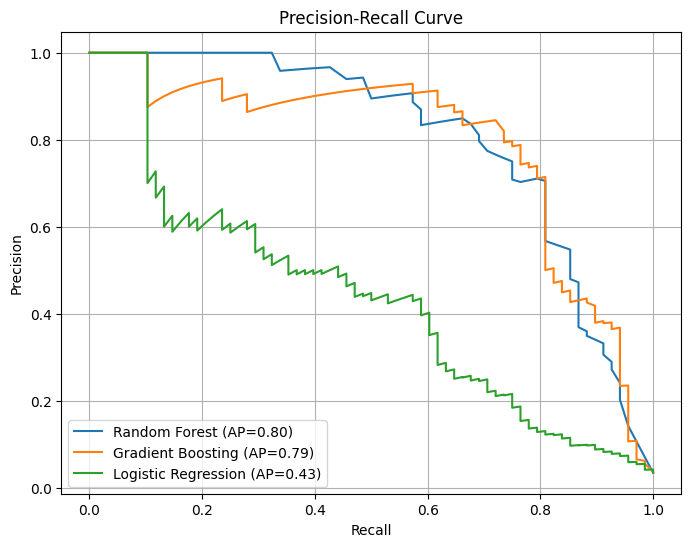

In [9]:
# Models
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression()
}

# Precision-Recall Curve
plt.figure(figsize=(8,6))
for name, model in models.items():
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


## Model 2: Failure Type Classification (Multi-Class)
### Prepare Data (Only for Failed Samples)

In [10]:
# Filter failed rows
failed_df = df[df['Machine failure'] == 1].copy()

# Target for Model 2
X_multi = failed_df[feature_cols]
y_multi = failed_df['failure_type']

# Encode labels
from sklearn.preprocessing import LabelEncoder
le_multi = LabelEncoder()
y_multi_encoded = le_multi.fit_transform(y_multi)

# Scale
X_multi_scaled = scaler.fit_transform(X_multi)

# Train-test split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_multi_scaled, y_multi_encoded, test_size=0.2, stratify=y_multi_encoded, random_state=42)

## Train Multi-Class Models


Decision Tree Classification Report:

              precision    recall  f1-score   support

         HDF       0.76      0.96      0.85        23
  No Failure       1.00      0.50      0.67         2
         OSF       0.77      0.62      0.69        16
         PWF       0.89      0.94      0.92        18
         TWF       0.83      0.56      0.67         9

    accuracy                           0.81        68
   macro avg       0.85      0.72      0.76        68
weighted avg       0.81      0.81      0.80        68



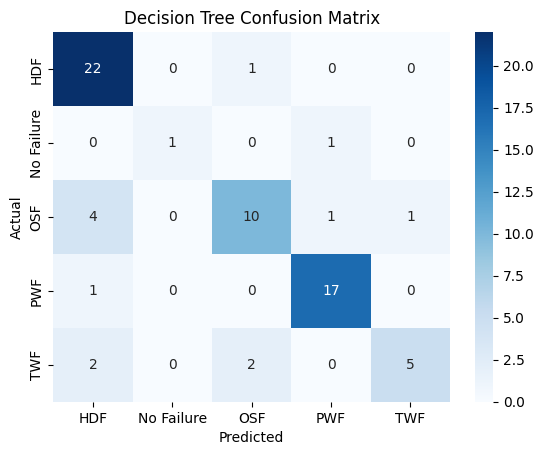


Naive Bayes Classification Report:

              precision    recall  f1-score   support

         HDF       0.69      0.96      0.80        23
  No Failure       0.00      0.00      0.00         2
         OSF       0.80      0.75      0.77        16
         PWF       0.80      0.67      0.73        18
         TWF       0.83      0.56      0.67         9

    accuracy                           0.75        68
   macro avg       0.62      0.59      0.59        68
weighted avg       0.74      0.75      0.73        68



C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


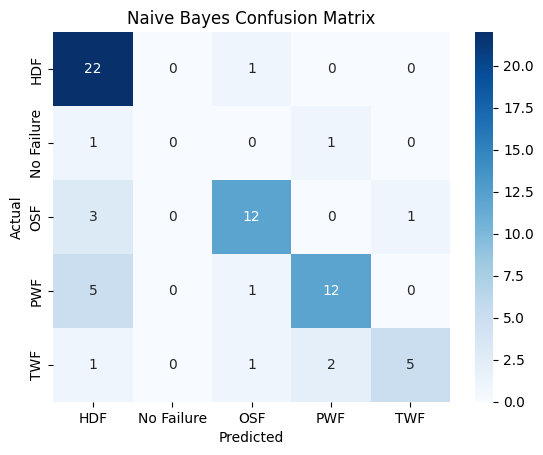


SVM Classification Report:

              precision    recall  f1-score   support

         HDF       0.77      1.00      0.87        23
  No Failure       0.00      0.00      0.00         2
         OSF       0.78      0.88      0.82        16
         PWF       0.79      0.61      0.69        18
         TWF       1.00      0.67      0.80         9

    accuracy                           0.79        68
   macro avg       0.67      0.63      0.64        68
weighted avg       0.78      0.79      0.78        68



C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


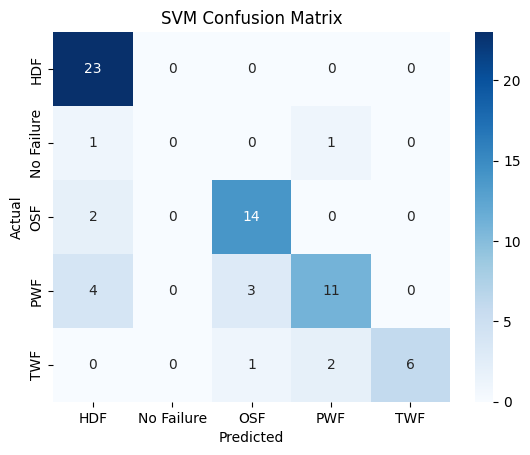

C:\Users\bbuser\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:37:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classification Report:

              precision    recall  f1-score   support

         HDF       0.88      1.00      0.94        23
  No Failure       1.00      1.00      1.00         2
         OSF       0.85      0.69      0.76        16
         PWF       0.95      1.00      0.97        18
         TWF       0.88      0.78      0.82         9

    accuracy                           0.90        68
   macro avg       0.91      0.89      0.90        68
weighted avg       0.89      0.90      0.89        68



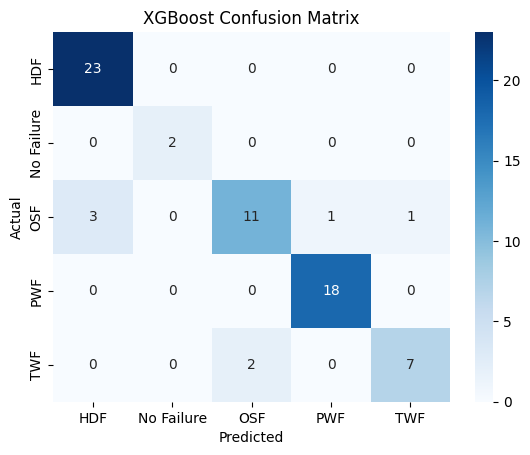

In [11]:
multi_models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "XGBoost": xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
}

for name, model in multi_models.items():
    model.fit(X_train_m, y_train_m)
    y_pred = model.predict(X_test_m)
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_test_m, y_pred, target_names=le_multi.classes_))
    
    cm = confusion_matrix(y_test_m, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_multi.classes_, yticklabels=le_multi.classes_, cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()